<h1>Приложение 2</h1>

<b>Примечание: </b> Каждый раздел первого уровня может запускаться отдельно.

<h2>1. Подсчёт метрик коллокационной силы Mutual Information и Lexical Gravity, их корреляции для всего корпуса REALEC</h2>

Рассматривались все содержащиеся в корпусе тексты на английском языке (5050 текстов, 1 762 431 слов).

In [33]:
import sqlite3, pandas

Откроем составленную базу данных и файл с SQL-скриптом:

In [34]:
db = sqlite3.connect('realec_database_full.db')

with open ('get_full_table.sql','r',encoding='utf-8') as source:
    query = source.read().split(';')

Выполним содержащиеся в скрипте запросы к базе данных:

In [ ]:
c = db.cursor()

for statement in query:
    c.execute(statement)
    
db.commit()

Запишем полученные сводные таблицы в объекты pandas: bigrams - для биграмм, составленных
из словоформ; lemma_bigrams - для биграмм, составленных из лемм, выделенных парсером udpipe (Биграммы выделялись только в пределах границ предложений, как в работе Гриса).

In [36]:
bigrams = pandas.read_sql('SELECT * FROM bigrams_with_freqs3 WHERE frequency>0',db,index_col='id')

In [37]:
lemma_bigrams = pandas.read_sql('SELECT * FROM lemma_bigrams_with_freqs1 WHERE frequency>0',db,index_col='id')

Найдём значения <b>метрики MI</b> для биграмм:

In [40]:
import math

N = list(db.execute('SELECT SUM(Frequency) FROM wordforms;'))[0][0]
bigrams['MI'] = bigrams.apply(lambda x: math.log(x['frequency'],
                                                 2)+math.log(N,2)-math.log(x['frequency:1'],2)
                              -math.log(x['frequency:2'],2),
                              axis=1)

In [41]:
lemma_bigrams['MI'] = lemma_bigrams.apply(lambda x: math.log(x['frequency'],
                                                 2)+math.log(N,2)-math.log(x['frequency:1'],2)
                              -math.log(x['frequency:2'],2),
                              axis=1)

In [42]:
db.close()

Теперь найдём значения <b>метрики Lexical Gravity</b> (G-score):

In [43]:
form_typesafter = bigrams['id_wordform1'].value_counts()
form_typesbefore = bigrams['id_wordform2'].value_counts()

lemma_typesafter = lemma_bigrams['id_lemma1'].value_counts()
lemma_typesbefore = lemma_bigrams['id_lemma2'].value_counts()

In [44]:
bigrams['G-score'] = bigrams.apply(lambda x: x['MI']-math.log(N,2)+math.log(x['frequency'],2)+
                                   math.log(form_typesafter[x['id_wordform1']],2)+
                                   math.log(form_typesbefore[x['id_wordform2']],2),axis = 1)

lemma_bigrams['G-score'] = lemma_bigrams.apply(lambda x: x['MI']-math.log(N,2)+math.log(x['frequency'],2)+
                                  math.log(lemma_typesafter[x['id_lemma1']],2)+
                                  math.log(lemma_typesbefore[x['id_lemma2']],2),axis = 1)

Найдём линейные парные <b>коэффициенты корреляции Пирсона</b> для частоты и метрик MI и Lexical Gravity:

In [53]:
correlations = bigrams.corr(method='pearson').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.024254,0.309222
MI,-0.024254,1.000000,0.263121
G-score,0.309222,0.263121,1.000000


In [54]:
lemma_correlations = lemma_bigrams.corr(method='pearson').drop(labels=['id_lemma1','frequency:1','frequency:2',
                                           'id_lemma2']).drop(labels=['id_lemma1',
                                                                      'frequency:1',
                                                                      'frequency:2',
                                                                      'id_lemma2'],axis=1)
lemma_correlations

,frequency,MI,G-score
frequency,1.000000,-0.023483,0.307553
MI,-0.023483,1.000000,0.261458
G-score,0.307553,0.261458,1.000000


Проверим полученные коэффициенты корреляции на значимость.  Для этого проверим гипотезу о том, что все коэффициенты корреляции равны нулю  при помощи <i>t</i>-теста Стьюдента.Пороговый
уровень значимости установим <i>a</i> = 0.05:

In [55]:
import scipy.stats

count_t_score = lambda x, n: x*((n-2)**0.5)/((1-x**2)**0.5)
p_value = lambda x, n: (1-scipy.stats.t.cdf(count_t_score(x,n),n-2))*2

n1 = len(bigrams.index)

correlations.applymap(lambda x: p_value(abs(x),n1) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


In [56]:
n2 = len(lemma_bigrams.index)

lemma_correlations.applymap(lambda x: p_value(abs(x),n2) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Нулевая гипотеза отвергается для всех коэффициентов корреляции, поэтому все из них можно считать значимыми

Теперь найдём <b>ранговые коэффициенты корреляции Спирмена и Кендалла</b>.

Найдём <b>коэффициент Спирмена</b>:

In [57]:
correlations = bigrams.corr(method='spearman').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.224737,0.671236
MI,-0.224737,1.000000,0.384513
G-score,0.671236,0.384513,1.000000


In [58]:
lemma_correlations = lemma_bigrams.corr(method='spearman').drop(labels=['id_lemma1','frequency:1','frequency:2',
                                           'id_lemma2']).drop(labels=['id_lemma1',
                                                                      'frequency:1',
                                                                      'frequency:2',
                                                                      'id_lemma2'],axis=1)
lemma_correlations

,frequency,MI,G-score
frequency,1.000000,-0.237772,0.679359
MI,-0.237772,1.000000,0.376915
G-score,0.679359,0.376915,1.000000


Проверим гипотезу о равенстве полученных коэффициентов нулю:

In [59]:
center_and_normalize = lambda x,n: x*((n-1)**0.5)

p_value = lambda x,n: (1-scipy.stats.norm.cdf(center_and_normalize(abs(x),n)))*2

correlations.applymap(lambda x: p_value(x,n1) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


In [60]:
lemma_correlations.applymap(lambda x: p_value(x,n2) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Здесь также нулевая гипотеза для всех значений отвергается.

Найдём <b>коэффициент Кенделла</b>:

In [61]:
correlations = bigrams.corr(method='kendall').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.172195,0.556361
MI,-0.172195,1.000000,0.285670
G-score,0.556361,0.285670,1.000000


In [62]:
lemma_correlations = lemma_bigrams.corr(method='kendall').drop(labels=['id_lemma1','frequency:1','frequency:2',
                                           'id_lemma2']).drop(labels=['id_lemma1',
                                                                      'frequency:1',
                                                                      'frequency:2',
                                                                      'id_lemma2'],axis=1)
lemma_correlations

,frequency,MI,G-score
frequency,1.000000,-0.181392,0.563584
MI,-0.181392,1.000000,0.281138
G-score,0.563584,0.281138,1.000000


Проверим на значимость:

In [63]:
center_and_normalize = lambda x,n: x*(((9*(n**2)-9*n)/(10*n+10))**0.5)
p_value = lambda x,n: (1-scipy.stats.norm.cdf(center_and_normalize(abs(x),n)))*2

correlations.applymap(lambda x: p_value(x,n1) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


In [64]:
lemma_correlations.applymap(lambda x: p_value(x,n2) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Все коэффициенты проходят проверку на значимость, так как вероятность истинности нулевой гипотезы настолько стремится
к нулю, что не помещается полностью в переменную типа float

Сохраним полученные значения метрик колллокационной силы вместе с таблицами биграмм:

In [65]:
bigrams.to_csv('realec_bigrams_full.csv')
lemma_bigrams.to_csv('realec_lemma_bigrams_full.csv')

Теперь посмотрим ранговую корреляцию для биграмм, у которых частота >= 2:

In [40]:
cut_by_threshold = lambda df, threshold: df.loc[df['frequency'] >= threshold]

In [43]:
bigrams = cut_by_threshold(pandas.read_csv('realec_bigrams_full.csv',index_col='id',encoding='ansi'),2)

Найдём <b>коэффициент Кенделла</b>:

In [44]:
correlations = bigrams.corr(method='kendall').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.057658,0.667701
MI,-0.057658,1.000000,0.203356
G-score,0.667701,0.203356,1.000000


Проверим на значимость:

In [46]:
n_bigrams = bigrams.shape[0]

In [47]:
n_bigrams

128624

In [53]:
center_and_normalize = lambda x,n: x*(((9*(n**2)-9*n)/(10*n+10))**0.5)
p_value = lambda x,n: (1-scipy.stats.norm.cdf(center_and_normalize(abs(x),n)))*2

correlations.applymap(lambda x: p_value(x,n_bigrams) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Найдём <b>коэффициент Спирмена</b>:

In [54]:
correlations = bigrams.corr(method='spearman').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.080990,0.806711
MI,-0.080990,1.000000,0.298085
G-score,0.806711,0.298085,1.000000


Проверим гипотезу о равенстве полученных коэффициентов нулю:

In [55]:
center_and_normalize = lambda x,n: x*((n-1)**0.5)

p_value = lambda x,n: (1-scipy.stats.norm.cdf(center_and_normalize(abs(x),n)))*2

correlations.applymap(lambda x: p_value(x,n_bigrams) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


<h2>2. Подсчёт метрик коллокационной силы Mutual Information и Lexical Gravity, их корреляции для корпуса LOCNESS</h2>

Рассматривались все тексты корпуса LOCNESS (413 текстов, 324 304 слова).

In [1]:
import sqlite3, pandas

Откроем составленную базу данных и файл с SQL-скриптом:

In [5]:
db = sqlite3.connect('locness_database_full.db')

with open ('get_full_table.sql','r',encoding='utf-8') as source:
    query = source.read().split(';')

Выполним содержащиеся в скрипте запросы к базе данных:

In [6]:
c = db.cursor()

for statement in query:
    c.execute(statement)
    
db.commit()

Запишем полученные сводные таблицы в объекты pandas: bigrams - для биграмм, составленных
из словоформ; lemma_bigrams - для биграмм, составленных из лемм, выделенных парсером udpipe (Биграммы выделялись только в пределах границ предложений, как в работе Гриса).

In [ ]:
bigrams = pandas.read_sql('SELECT * FROM bigrams_with_freqs3 WHERE frequency>0',db,index_col='id')

lemma_bigrams = pandas.read_sql('SELECT * FROM lemma_bigrams_with_freqs1 WHERE frequency>0',db,index_col='id')

Найдём значения <b>метрики MI</b> для биграмм:

In [9]:
import math

N = list(db.execute('SELECT SUM(Frequency) FROM wordforms;'))[0][0]
bigrams['MI'] = bigrams.apply(lambda x: math.log(x['frequency'],
                                                 2)+math.log(N,2)-math.log(x['frequency:1'],2)
                              -math.log(x['frequency:2'],2),
                              axis=1)

In [10]:
lemma_bigrams['MI'] = lemma_bigrams.apply(lambda x: math.log(x['frequency'],
                                                 2)+math.log(N,2)-math.log(x['frequency:1'],2)
                              -math.log(x['frequency:2'],2),
                              axis=1)

In [11]:
db.close()

Теперь найдём значения <b>метрики Lexical Gravity</b> (G-score):

In [12]:
form_typesafter = bigrams['id_wordform1'].value_counts()
form_typesbefore = bigrams['id_wordform2'].value_counts()

lemma_typesafter = lemma_bigrams['id_lemma1'].value_counts()
lemma_typesbefore = lemma_bigrams['id_lemma2'].value_counts()

In [13]:
bigrams['G-score'] = bigrams.apply(lambda x: x['MI']-math.log(N,2)+math.log(x['frequency'],2)+
                                   math.log(form_typesafter[x['id_wordform1']],2)+
                                   math.log(form_typesbefore[x['id_wordform2']],2),axis = 1)

lemma_bigrams['G-score'] = lemma_bigrams.apply(lambda x: x['MI']-math.log(N,2)+math.log(x['frequency'],2)+
                                  math.log(lemma_typesafter[x['id_lemma1']],2)+
                                  math.log(lemma_typesbefore[x['id_lemma2']],2),axis = 1)

Найдём линейные парные <b>коэффициенты корреляции Пирсона</b> для частоты и метрик MI и Lexical Gravity:

In [16]:
correlations = bigrams.corr(method='pearson').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.052091,0.371785
MI,-0.052091,1.000000,0.181861
G-score,0.371785,0.181861,1.000000


Теперь найдём <b>ранговые коэффициенты корреляции Спирмена и Кендалла</b>.

Найдём <b>коэффициент Спирмена</b>:

In [21]:
correlations = bigrams.corr(method='spearman').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.246435,0.658432
MI,-0.246435,1.000000,0.343401
G-score,0.658432,0.343401,1.000000


Найдём <b>коэффициент Кенделла</b>:

In [6]:
correlations = bigrams.corr(method='kendall').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,id,frequency,MI,G-score
id,1.000000,-0.313668,0.246568,-0.095631
frequency,-0.313668,1.000000,-0.192800,0.548591
MI,0.246568,-0.192800,1.000000,0.261713
G-score,-0.095631,0.548591,0.261713,1.000000


Сохраним полученные значения метрик колллокационной силы вместе с таблицами биграмм:

In [19]:
bigrams.to_csv('locness_bigrams_full.csv')
lemma_bigrams.to_csv('locness_lemma_bigrams_full.csv')

Теперь посмотрим ранговую корреляцию для биграмм, у которых частота >= 2:

In [40]:
cut_by_threshold = lambda df, threshold: df.loc[df['frequency'] >= threshold]

In [56]:
bigrams = cut_by_threshold(pandas.read_csv('locness_bigrams_full.csv',index_col='id',encoding='ansi'),2)

Найдём <b>коэффициент Кенделла</b>:

In [57]:
correlations = bigrams.corr(method='kendall').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.073167,0.695589
MI,-0.073167,1.000000,0.117361
G-score,0.695589,0.117361,1.000000


Проверим на значимость:

In [58]:
n_bigrams = bigrams.shape[0]

In [59]:
n_bigrams

33830

In [60]:
center_and_normalize = lambda x,n: x*(((9*(n**2)-9*n)/(10*n+10))**0.5)
p_value = lambda x,n: (1-scipy.stats.norm.cdf(center_and_normalize(abs(x),n)))*2

correlations.applymap(lambda x: p_value(x,n_bigrams) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Найдём <b>коэффициент Спирмена</b>:

In [61]:
correlations = bigrams.corr(method='spearman').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.099859,0.828294
MI,-0.099859,1.000000,0.174198
G-score,0.828294,0.174198,1.000000


Проверим гипотезу о равенстве полученных коэффициентов нулю:

In [62]:
center_and_normalize = lambda x,n: x*((n-1)**0.5)

p_value = lambda x,n: (1-scipy.stats.norm.cdf(center_and_normalize(abs(x),n)))*2

correlations.applymap(lambda x: p_value(x,n_bigrams) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


<h2>3. Анализ распределения метрик для корпусов</h2>

In [2]:
import pandas, math
import matplotlib.pyplot as plt

realec_bigrams = pandas.read_csv('realec_bigrams_full.csv',encoding='ansi')
realec_lemma_bigrams = pandas.read_csv('realec_lemma_bigrams_full.csv',encoding='ansi')
locness_bigrams = pandas.read_csv('locness_bigrams_full.csv',encoding='ansi')

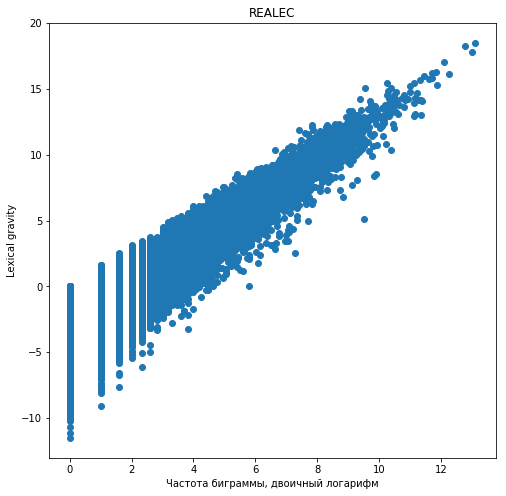

In [11]:
plt.figure(figsize=(8,8))
plt.scatter(realec_bigrams['frequency'].apply(lambda x: math.log(x,2)),realec_bigrams['G-score'])
plt.xlabel('Частота биграммы, двоичный логарифм')
plt.ylabel('Lexical gravity')
plt.title('REALEC')
plt.savefig('figures/realec_full_frequency_gravity_corr.png',bbox_inches='tight')
plt.show()

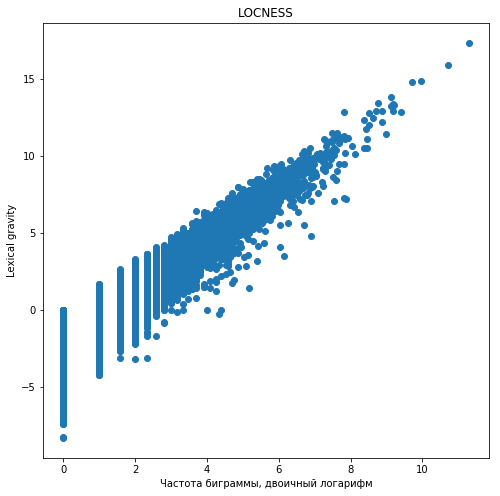

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(locness_bigrams['frequency'].apply(lambda x: math.log(x,2)),locness_bigrams['G-score'])
plt.xlabel('Частота биграммы, двоичный логарифм')
plt.ylabel('Lexical gravity')
plt.title('LOCNESS')
plt.savefig('figures/locness_full_frequency_gravity_corr.png',bbox_inches='tight')
plt.show()

Коэффициент корреляции для логарифма частоты и Lexical Gravity:

In [4]:
realec_bigrams['frequency'].apply(lambda x: math.log(x,2)).corr(realec_bigrams['G-score'])

0.8418298993834894

In [14]:
locness_bigrams['frequency'].apply(lambda x: math.log(x,2)).corr(locness_bigrams['G-score'])

0.8528880694856477

Коэффициент корреляции для логарифма частоты и MI:

In [5]:
realec_bigrams['frequency'].apply(lambda x: math.log(x,2)).corr(realec_bigrams['MI'])

-0.18004613799848274

Коэффициент корреляции для суммы логарифмов частот слов в биграмме и Lexical Gravity:

In [7]:
sum_freqs = realec_bigrams['frequency:1'].add(realec_bigrams['frequency:2'])
sum_freqs.apply(lambda x: math.log(x,2)).corr(realec_bigrams['G-score'])

-0.08408400649485318

Коэффициент корреляции для суммы логарифмов частот слов в биграмме и MI:

In [8]:
sum_freqs.apply(lambda x: math.log(x,2)).corr(realec_bigrams['MI'])

-0.7526865336601186

Коэффициент корреляции для частоты слова и typesafter:

In [13]:
import sqlite3

realec_form_typesafter = realec_bigrams['id_wordform1'].value_counts()
realec_form_typesbefore = realec_bigrams['id_wordform2'].value_counts()

db = sqlite3.connect('P:/Studies/2nd-year-thesis/realec_database_full.db')
wordforms = pandas.read_sql('SELECT * FROM wordforms WHERE frequency>0',db,index_col='id')
wordform_frequencies = wordforms['frequency']

wordform_frequencies.corr(realec_form_typesafter)

0.9226447376681641

Коэффициент корреляции для частоты слова и typesbefore:

In [14]:
wordform_frequencies.corr(realec_form_typesbefore)

0.8733336710788874

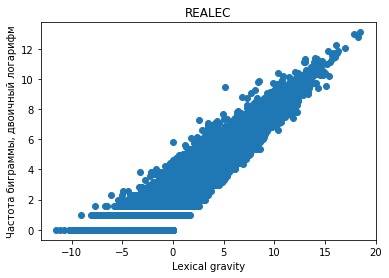

In [9]:
plt.scatter(realec_bigrams['G-score'],realec_bigrams['frequency'].apply(lambda x: math.log(x,2)))
plt.ylabel('Частота биграммы, двоичный логарифм')
plt.xlabel('Lexical gravity')
plt.title('REALEC')
plt.show()

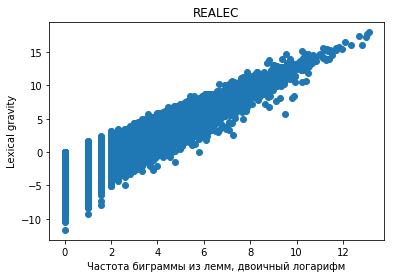

In [8]:
plt.scatter(realec_lemma_bigrams['frequency'].apply(lambda x: math.log(x,2)),realec_lemma_bigrams['G-score'])
plt.xlabel('Частота биграммы из лемм, двоичный логарифм')
plt.ylabel('Lexical gravity')
plt.title('REALEC')
plt.show()

In [3]:
realec_lemma_bigrams['frequency'].apply(lambda x: math.log(x,2)).corr(realec_lemma_bigrams['G-score'])

0.8475688554451599

<h2>4. Кластерный анализ частей корпуса</h2>

In [1]:
import matplotlib.pyplot as plt
import sqlite3, pandas
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.spatial.distance import pdist
from scipy.stats import zscore
import numpy as np
import math

Определим функцию для преобразования файла базы данных в нужный нам датафрейм:

<h3> 4.1. Препроцессинг </h3>

In [2]:
def process_data(db_fp):
    db = sqlite3.connect(db_fp)
    print('connected to database')
    with open ('get_full_table.sql','r',encoding='utf-8') as source:
        query = source.read().split(';')
    c = db.cursor()
    for statement in query:
        c.execute(statement)
    bigrams = pandas.read_sql('SELECT * FROM bigrams_with_freqs3 WHERE frequency>0',db,index_col='id')
    print('DataFrame constructed')
    N = list(db.execute('SELECT SUM(Frequency) FROM wordforms;'))[0][0]
    bigrams['MI'] = bigrams.apply(lambda x: math.log(x['frequency'],
                                                 2)+math.log(N,2)-math.log(x['frequency:1'],2)
                              -math.log(x['frequency:2'],2),
                              axis=1)
    print('MI calculated')
    print('G-scores calculated')
    form_typesafter = bigrams['id_wordform1'].value_counts()
    form_typesbefore = bigrams['id_wordform2'].value_counts()
    bigrams['G-score'] = bigrams.apply(lambda x: x['MI']-math.log(N,2)+math.log(x['frequency'],2)+
                                   math.log(form_typesafter[x['id_wordform1']],2)+
                                   math.log(form_typesbefore[x['id_wordform2']],2),axis = 1)
    db.close()
    print('done')
    return bigrams

Применим функцию к нашим подкорпусам:
 - REALEC
  - Райтинги IELTS (папка exam)
  - Академическое письмо
  - Сочинения МАГОЛЕГО
  - Сочинения МПГУ
 - LOCNESS
  - A-Levels
  - American argumnetative
  - British argumentative

In [3]:
ielts_frame = process_data('ielts_works.db')

connected to database
DataFrame constructed
MI calculated
G-scores calculated
done


In [4]:
aw_frame = process_data('academic_writing.db')

connected to database
DataFrame constructed
MI calculated
G-scores calculated
done


In [5]:
mpgu_frame = process_data('pedagogish_essays.db')

connected to database
DataFrame constructed
MI calculated
G-scores calculated
done


In [6]:
magolego_frame = process_data('magolego_database.db')

connected to database
DataFrame constructed
MI calculated
G-scores calculated
done


In [7]:
alevels_frame = process_data('locness_alevels_database.db')
usarg_frame = process_data('usarg_database.db')
brsur_frame = process_data('brsur_database.db')

connected to database
DataFrame constructed
MI calculated
G-scores calculated
done
connected to database
DataFrame constructed
MI calculated
G-scores calculated
done
connected to database
DataFrame constructed
MI calculated
G-scores calculated
done


In [8]:
ielts_frame.to_csv('ielts_bigrams.csv')
aw_frame.to_csv('aw_bigrams.csv')
mpgu_frame.to_csv('mpgu_bigrams.csv')
magolego_frame.to_csv('magolego_bigrams.csv')
usarg_frame.to_csv('usarg_bigrams.csv')
brsur_frame.to_csv('brsur_bigrams.csv')
alevels_frame.to_csv('locness_alevels_bigrams.csv')

<h3> 4.2. Кластерный анализ данных </h3>

In [6]:
ielts_frame = pandas.read_csv('ielts_bigrams.csv',encoding='ansi',index_col='id')
aw_frame = pandas.read_csv('aw_bigrams.csv',encoding='ansi',index_col='id')
mpgu_frame = pandas.read_csv('mpgu_bigrams.csv',encoding='ansi',index_col='id')
magolego_frame = pandas.read_csv('magolego_bigrams.csv',encoding='ansi',index_col='id')
usarg_frame = pandas.read_csv('usarg_bigrams.csv',encoding='ansi',index_col='id')
brsur_frame = pandas.read_csv('brsur_bigrams.csv',encoding='ansi',index_col='id')
alevels_frame = pandas.read_csv('locness_alevels_bigrams.csv',encoding='ansi',index_col='id')

In [7]:
def create_comparision_frame(metric, threshold = 0):
    cut_by_threshold = lambda df: df.loc[df['frequency'] >= threshold]
    ielts_scores = cut_by_threshold(ielts_frame)[metric]
    aw_scores = cut_by_threshold(aw_frame)[metric]
    mpgu_scores = cut_by_threshold(mpgu_frame)[metric]
    magolego_scores = cut_by_threshold(magolego_frame)[metric]
    alevels_scores = cut_by_threshold(alevels_frame)[metric]
    usarg_scores = cut_by_threshold(usarg_frame)[metric]
    brsur_scores = cut_by_threshold(brsur_frame)[metric]

    ielts_scores = ielts_scores.rename('REALEC_IELTS')
    aw_scores = aw_scores.rename('REALEC_AW')
    mpgu_scores = mpgu_scores.rename('REALEC_MPGU')
    magolego_scores = magolego_scores.rename('REALEC_MAGOLEGO')
    alevels_scores = alevels_scores.rename('LOCNESS_ALEV')
    usarg_scores = usarg_scores.rename('LOCNESS_USARG')
    brsur_scores = brsur_scores.rename('LOCNESS_BRSUR')
    scores = pandas.concat([ielts_scores, aw_scores, mpgu_scores, magolego_scores, alevels_scores,
                              usarg_scores,brsur_scores],axis=1)
    return scores

<h4>4.2.1. При помощи векторных расстояний</h4>

In [8]:
G_scores_intersec = create_comparision_frame('G-score',threshold=2).dropna()
frequency_counts_intersec = create_comparision_frame('frequency',threshold=2).dropna().applymap(lambda x: math.log(x,2))
PMI_counts_intersec = create_comparision_frame('MI',threshold=2).dropna()
corpus_labels = [i for i in G_scores_intersec]

Сколько биграмм попало в датафрейм?

In [9]:
G_scores_intersec.shape

(612, 7)

Строим дендрограммы по Gravity, частоте и PMI, используя косинусное расстояние:

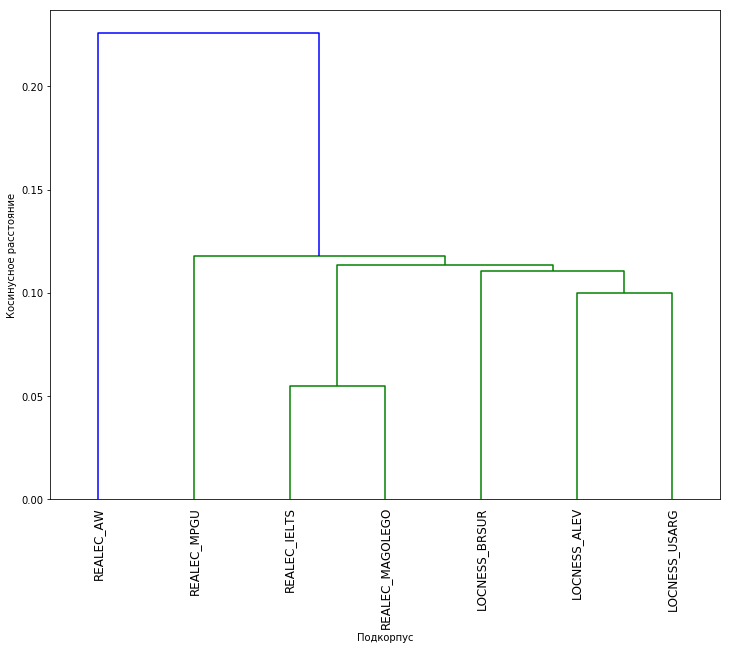

In [12]:
tree = linkage(pdist(G_scores_intersec.transpose(),metric='cosine'))
plt.figure(figsize=(12,9))
plt.ylabel('Косинусное расстояние')
plt.xlabel('Подкорпус')
dendrogram(tree, labels = corpus_labels, leaf_rotation = 90)
plt.savefig('./figures_clusters/Gravity_dendrogram_intersection_cosine_threshold=2.png',bbox_inches='tight')
plt.show()

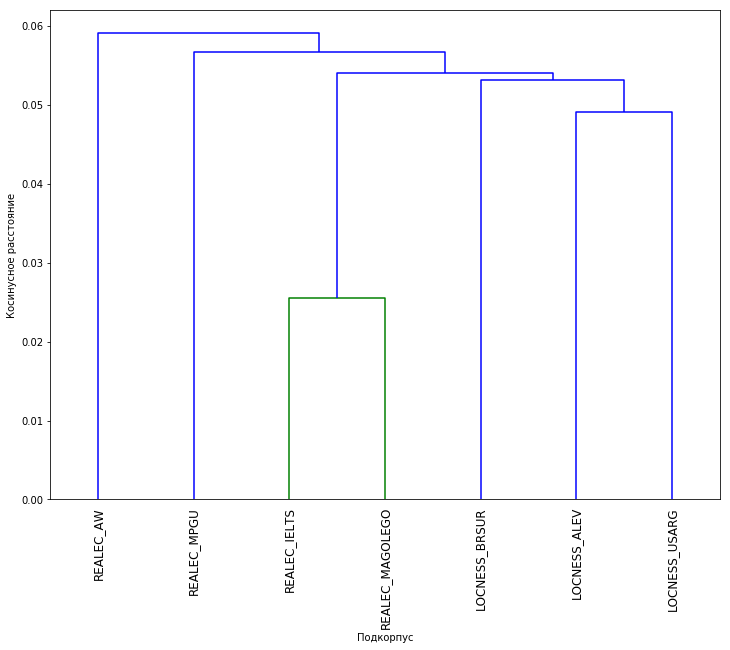

In [13]:
tree = linkage(pdist(frequency_counts_intersec.transpose(),metric='cosine'))
plt.figure(figsize=(12,9))
plt.ylabel('Косинусное расстояние')
plt.xlabel('Подкорпус')
dendrogram(tree, labels = corpus_labels, leaf_rotation = 90)
plt.savefig('./figures_clusters/Frequency_dendrogram_intersection_cosine_threshold=2.png',bbox_inches='tight')
plt.show()

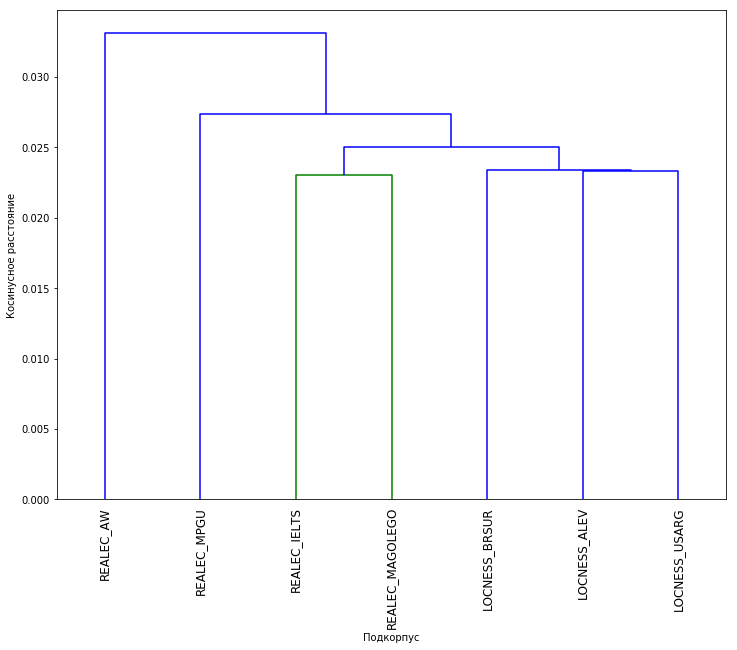

In [29]:
tree = linkage(pdist(PMI_counts_intersec.transpose(),metric='cosine'))
plt.figure(figsize=(12,9))
plt.ylabel('Косинусное расстояние')
plt.xlabel('Подкорпус')
dendrogram(tree, labels = corpus_labels, leaf_rotation = 90)
plt.savefig('./figures_clusters/MI_dendrogram_intersection_cosine_threshold=2.png',bbox_inches='tight')
plt.show()

Строим дендрограммы по gravity и частоте, $z$-стандартизируя значения и используя Евклидово расстояние:

[[ 0.          3.         16.90089395  2.        ]
 [ 4.          5.         19.18344438  2.        ]
 [ 2.          6.         20.05349423  2.        ]
 [ 8.          9.         20.76211724  4.        ]
 [ 7.         10.         21.59195413  6.        ]
 [ 1.         11.         22.13594851  7.        ]]


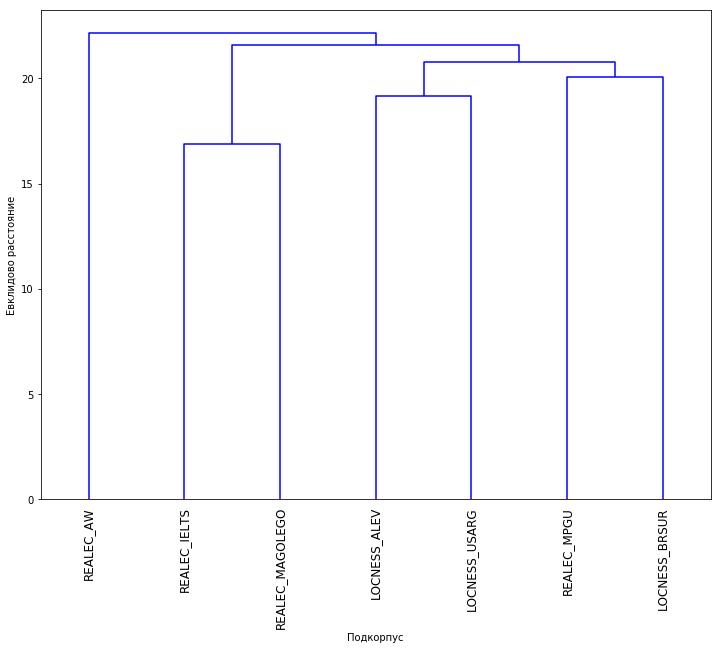

In [27]:
tree = linkage(G_scores_intersec.apply(zscore).transpose())
print(tree)
plt.figure(figsize=(12,9))
plt.ylabel('Евклидово расстояние')
plt.xlabel('Подкорпус')
dendrogram(tree, labels = corpus_labels, leaf_rotation = 90)
plt.savefig('./figures_clusters/Gravity_dendrogram_intersection_zscore_threshold=2.png',bbox_inches='tight')
plt.show()

[[ 0.          3.         16.42330191  2.        ]
 [ 4.          5.         18.68606976  2.        ]
 [ 2.          6.         19.74111586  2.        ]
 [ 8.          9.         19.94870765  4.        ]
 [ 7.         10.         21.07292794  6.        ]
 [ 1.         11.         21.37818374  7.        ]]


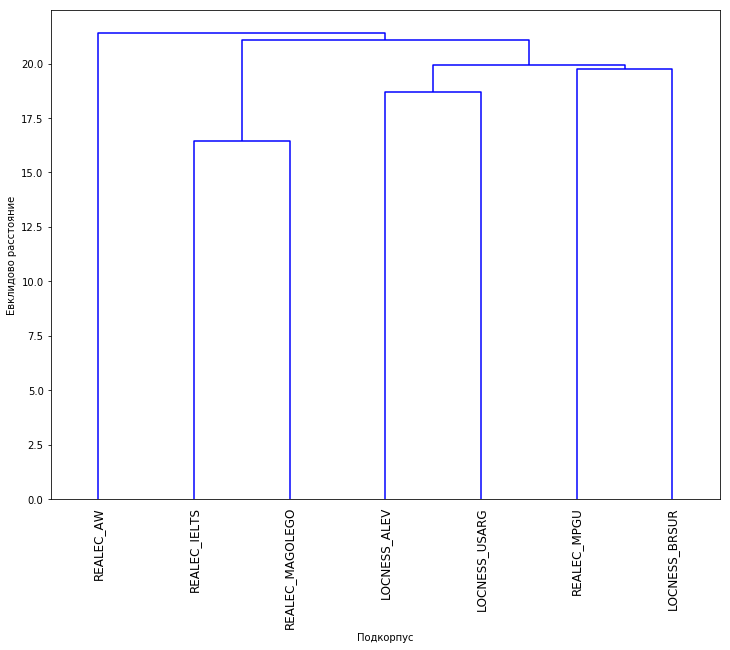

In [28]:
tree = linkage(frequency_counts_intersec.apply(zscore).transpose())
print(tree)
plt.figure(figsize=(12,9))
plt.ylabel('Евклидово расстояние')
plt.xlabel('Подкорпус')
dendrogram(tree, labels = corpus_labels, leaf_rotation = 90)
plt.savefig('./figures_clusters/Frequency_dendrogram_intersection_zscore_threshold=2.png',bbox_inches='tight')
plt.show()

Строим по PMI без нормализации/стандартизации, используя Евклидово расстояние:

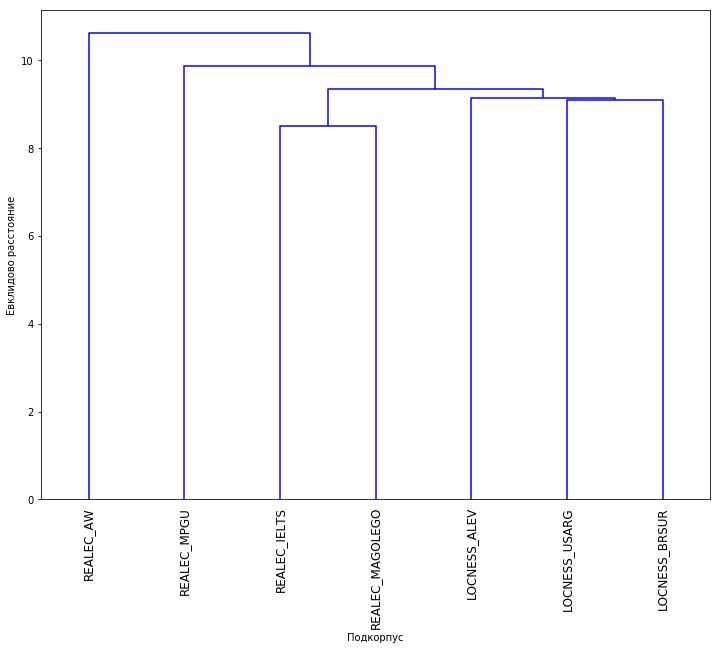

In [16]:
tree = linkage(PMI_counts_intersec.apply(zscore).transpose())
plt.figure(figsize=(12,9))
plt.ylabel('Евклидово расстояние')
plt.xlabel('Подкорпус')
dendrogram(tree, labels = corpus_labels, leaf_rotation = 90)
plt.savefig('./figures_clusters/MI_dendrogram_intersection_threshold=2.png',bbox_inches='tight')
plt.show()

Посмотрим корреляции (по Пирсону):

In [25]:
G_scores_intersec.corrwith(frequency_counts_intersec)

REALEC_IELTS       0.954517
REALEC_AW          0.954433
REALEC_MPGU        0.957089
REALEC_MAGOLEGO    0.958624
LOCNESS_ALEV       0.959726
LOCNESS_USARG      0.958820
LOCNESS_BRSUR      0.958413
dtype: float64

In [26]:
G_scores_intersec.corrwith(PMI_counts_intersec)

REALEC_IELTS       0.205501
REALEC_AW          0.187473
REALEC_MPGU        0.090965
REALEC_MAGOLEGO    0.179861
LOCNESS_ALEV       0.139034
LOCNESS_USARG      0.138859
LOCNESS_BRSUR      0.070381
dtype: float64

In [27]:
frequency_counts_intersec.corrwith(PMI_counts_intersec)

REALEC_IELTS       0.169388
REALEC_AW          0.152958
REALEC_MPGU        0.064004
REALEC_MAGOLEGO    0.208495
LOCNESS_ALEV       0.144537
LOCNESS_USARG      0.138239
LOCNESS_BRSUR      0.074380
dtype: float64

<h4>4.2.2. При помощи расстояния Кенделла (Kendall's Tau distance)</h4>

In [17]:
tau_dist = lambda x,y: (1-scipy.stats.kendalltau(x,y)[0])/2

In [18]:
import scipy.spatial.distance

In [19]:
def frame_kendall_corr(x,y):
    corrs = dict()
    for i in x:
        corrs[i] = scipy.stats.kendalltau(x[i],y[i])[0]
    return pandas.Series(corrs)

In [20]:
G_scores_intersec = create_comparision_frame('G-score',threshold=2).dropna()
frequency_counts_intersec = create_comparision_frame('frequency',threshold=2).dropna().applymap(lambda x: math.log(x,2))
PMI_counts_intersec = create_comparision_frame('MI',threshold=2).dropna()
corpus_labels = [i for i in G_scores_intersec]

Строим дерево по Gravity:

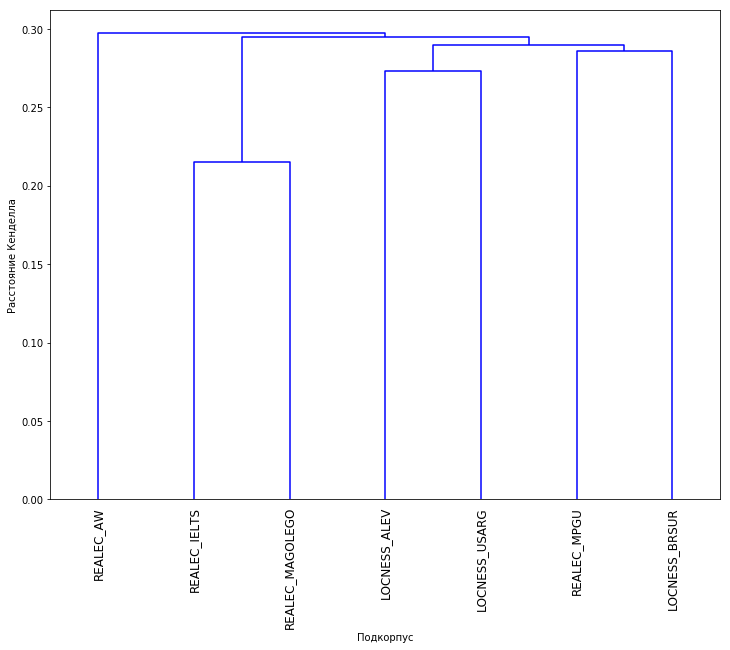

In [21]:
g_distances = scipy.spatial.distance.pdist(G_scores_intersec.transpose(), metric=tau_dist)
tree_g = linkage(g_distances)
plt.figure(figsize=(12,9))
plt.ylabel('Расстояние Кенделла')
plt.xlabel('Подкорпус')
dendrogram(tree_g, labels = corpus_labels, leaf_rotation = 90)
plt.savefig('./figures_clusters/Gravity_dendrogram_intersection_kendalltau_threshold=2.png',bbox_inches='tight')
plt.show()

Строим дерево по частоте:

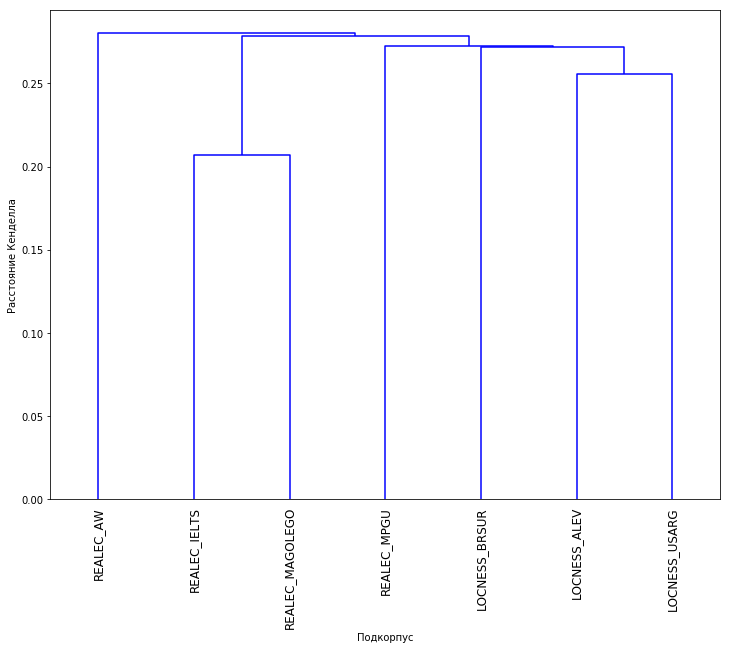

In [22]:
f_distances = scipy.spatial.distance.pdist(frequency_counts_intersec.transpose(), metric=tau_dist)
tree_f = linkage(f_distances)
plt.figure(figsize=(12,9))
plt.ylabel('Расстояние Кенделла')
plt.xlabel('Подкорпус')
dendrogram(tree_f, labels = corpus_labels, leaf_rotation = 90)
plt.savefig('./figures_clusters/Frequency_dendrogram_intersection_kendalltau_threshold=2.png',bbox_inches='tight')
plt.show()

Строим дерево по PMI:

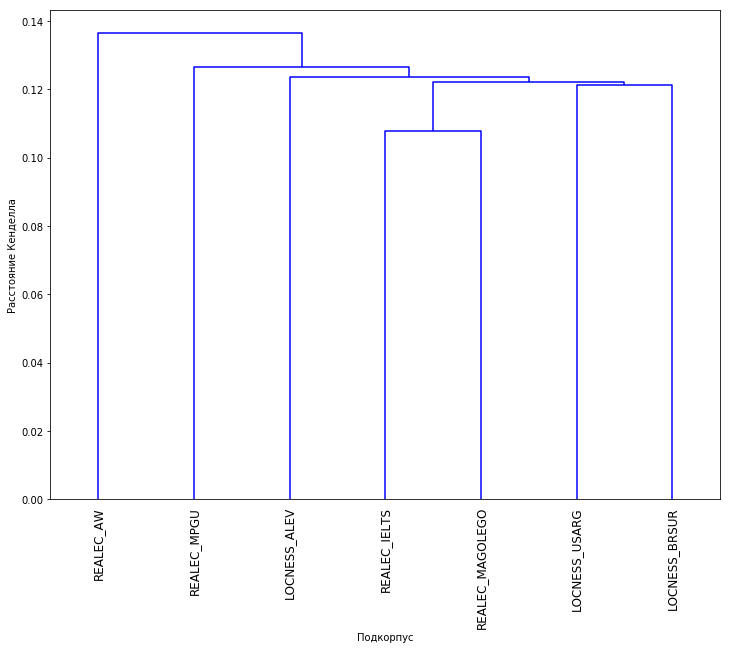

In [23]:
pmi_distances = scipy.spatial.distance.pdist(PMI_counts_intersec.transpose(), metric=tau_dist)
tree_pmi = linkage(pmi_distances)
plt.figure(figsize=(12,9))
plt.ylabel('Расстояние Кенделла')
plt.xlabel('Подкорпус')
dendrogram(tree_pmi, labels = corpus_labels, leaf_rotation = 90)
plt.savefig('./figures_clusters/MI_dendrogram_intersection_kendalltau_threshold=2.png',bbox_inches='tight')
plt.show()

Найдём коэффициент корреляции Кенделла между метриками:

In [24]:
frame_kendall_corr(G_scores_intersec, frequency_counts_intersec)

LOCNESS_ALEV       0.842977
LOCNESS_BRSUR      0.836865
LOCNESS_USARG      0.845546
REALEC_AW          0.832502
REALEC_IELTS       0.818239
REALEC_MAGOLEGO    0.837972
REALEC_MPGU        0.831575
dtype: float64

In [25]:
frame_kendall_corr(G_scores_intersec, PMI_counts_intersec)

LOCNESS_ALEV       0.115141
LOCNESS_BRSUR      0.078605
LOCNESS_USARG      0.115332
REALEC_AW          0.146233
REALEC_IELTS       0.152905
REALEC_MAGOLEGO    0.135561
REALEC_MPGU        0.082623
dtype: float64

In [26]:
frame_kendall_corr(PMI_counts_intersec, frequency_counts_intersec)

LOCNESS_ALEV       0.123727
LOCNESS_BRSUR      0.085016
LOCNESS_USARG      0.121378
REALEC_AW          0.130123
REALEC_IELTS       0.136493
REALEC_MAGOLEGO    0.161577
REALEC_MPGU        0.070297
dtype: float64

In [32]:
G_scores_intersec.to_csv('tables/G_scores_intersec.csv',sep=';')
frequency_counts_intersec.to_csv('tables/frequency_counts_intersec.csv',sep=';')
PMI_counts_intersec.to_csv('tables/PMI_counts_intersec.csv',sep=';')

<h2> 5. Биграммы типа существительное+прилагательное, наиболее отличающиеся по Gravity и PMI</h2>

In [1]:
import pandas

In [2]:
realec_frame = pandas.read_csv('realec_bigrams_full.csv', encoding='ansi', index_col = 'id')
locness_frame = pandas.read_csv('locness_bigrams_full.csv', encoding='ansi', index_col = 'id')

In [9]:
def select_needed_pos(df, p1, p2):
    return df.loc[(df['pos'] == p1) & (df['pos:1'] == p2)]

In [10]:
realec_adj_n = select_needed_pos(realec_frame, 'ADJ', 'NOUN')

In [12]:
locness_adj_n = select_needed_pos(locness_frame, 'ADJ', 'NOUN')[['MI','G-score']]

In [17]:
locness_adj_n = locness_adj_n.rename(columns = {'MI':'LOCNESS MI', 'G-score':'LOCNESS G-score'})

In [19]:
realec_adj_n = realec_adj_n.rename(columns = {'MI':'REALEC MI', 'G-score':'REALEC G-score'})

In [25]:
comparision = pandas.concat([realec_adj_n, locness_adj_n], axis=1).dropna()

In [32]:
comparision = comparision.drop(['frequency','frequency:1','frequency:2'], axis = 1)

In [35]:
comparision = comparision.drop(['id_wordform1','id_wordform2','pos','pos:1'],axis=1)

Применим к метрикам z-score:

In [27]:
from scipy.stats import zscore

In [28]:
comparision = comparision.apply(lambda x: zscore(x) if ('G-score' in x.name) or ('MI' in x.name) else x)

In [29]:
comparision['MI_diff'] = comparision.apply(lambda x: abs(x['REALEC MI']-x['LOCNESS MI']), axis = 1)
comparision['G-score diff'] = comparision.apply(lambda x: abs(x['REALEC G-score']-x['LOCNESS G-score']), axis = 1)

Отсортируем по разнице метрик:

In [39]:
comparision.sort_values(by='MI_diff', ascending=False)

,bigram,REALEC MI,REALEC G-score,LOCNESS MI,LOCNESS G-score,MI_diff,G-score diff
id,,,,,,,
162743,vitro fertilization,5.222467,0.020844,2.450668,-0.466874,2.771799,0.487718
178894,christian religion,3.424768,-0.235284,0.686978,-0.372635,2.737789,0.137350
419092,presidential election,3.880287,0.567921,1.249271,-0.476051,2.631016,1.043972
261470,russian children,-1.786685,-1.300841,0.817761,-0.566005,2.604446,0.734837
328661,ethnic backgrounds,3.055038,0.401972,0.548919,-1.051058,2.506119,1.453030
159924,multinational company,0.419496,-1.188841,2.839789,-0.169875,2.420293,1.018966
202006,nuclear war,2.043954,0.693139,-0.363909,-1.310878,2.407863,2.004017
149324,popular sportsmen,-0.597904,-0.989367,1.724930,0.162315,2.322834,1.151683
3957,human ',0.564374,1.955066,-1.748220,-1.240053,2.312594,3.195119


In [40]:
comparision.sort_values(by='G-score diff', ascending=False)

,bigram,REALEC MI,REALEC G-score,LOCNESS MI,LOCNESS G-score,MI_diff,G-score diff
id,,,,,,,
156229,public schools,-0.612715,-0.562151,0.986600,4.555061,1.599314,5.117212
17794,public health,1.369530,3.942295,-0.603919,-0.876729,1.973449,4.819024
385366,bad faith,0.878874,-0.125737,1.565309,4.334150,0.686435,4.459888
418999,new age,-2.170481,-1.463367,0.027616,2.913551,2.198097,4.376918
374204,public school,-1.507271,-1.304247,0.226852,3.036735,1.734123,4.340982
6264,such people,-1.161012,2.438142,-2.979580,-1.678353,1.818568,4.116495
96787,primary education,1.042970,3.292793,-0.144533,-0.791157,1.187503,4.083951
12299,good way,-0.180811,2.571007,-2.087337,-1.509504,1.906526,4.080511
133967,nuclear power,1.212458,0.044543,1.025764,4.087153,0.186694,4.042610
